## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [38]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk #to add words to stop words
import re
import string

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set seed
import random
random.seed(10)

#word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#topic modeling
from sklearn.decomposition import LatentDirichletAllocation

In [39]:
#import file 
congress_tweets = pd.read_csv("C://Users/mjkeh/CSS_Project5_Team3_Spring2022/data/116th Congressional Tweets and Demographics.csv")
#congress_tweets = pd.read_csv("/Users/neldeeb/Desktop/Spring 2022/Comp Social Sci - 273/Projects/Computational Social Science Project 5/data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [40]:
#check the size of the dataset
congress_tweets.shape


(946791, 16)

In [41]:
#subset the data
## fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(frac=0.01, random_state=0)
congress_tweets.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [42]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [43]:
#check the size of the new dataset
congress_tweets.shape

(9468, 16)

In [44]:
#text data
congress_tweets['text'].head()

0    All of #OH14 salutes you, Patrolman St. Clair!...
1    In Case You Missed It: Bipartisanship works – ...
2    Wishing a happy #Passover to all those celebra...
3    RT @WhiteHouse President @realDonaldTrump just...
4    I just sent a letter demanding the Administrat...
Name: text, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [45]:
#NE: Remove emojis - FOUND ON GITHUB

def rem_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            u"\u200d"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_emoji)

In [46]:
#NE: Remove urls - FOUND ON STACK OVERFLOW
#MJ: fixed typo in "apply(rem_urls)"
def rem_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text' 
congress_tweets['text'] = congress_tweets['text'].apply(rem_urls)

In [47]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt") #NE: to get rid of retweets 
    nlp.Defaults.stop_words.add("RT") #MJ: to get rid of rt in capital letters
    nlp.Defaults.stop_words.add("qt") #NE: to get rid of quote tweets 
    nlp.Defaults.stop_words.add("QT") #MJ: to get rid of qt in capital letters
    nlp.Defaults.stop_words.add("amp") #NE: to get rid of accelerated mobile pages
    nlp.Defaults.stop_words.add("AMP") #MJ: to get rid of accelerated mobile pages in capital letters
   # nlp.Defaults.stop_words.add("need") #NE: to get rid of the word "need" big on all wordclouds (thoughts?) ##MJ : it may mean something, so I removed "need" from stop words
   # nlp.Defaults.stop_words.add("today") #NE: to get rid of the word "today" big on all wordclouds (thoughts?) ##MJ : it may mean something, so I removed "today" from stop words    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    #create tokens
    spacy_words = [token.text.lower() for token in doc] #NE: if we want to make the text all lower case 
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')] #MJ: this also removes some of the urls?
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [48]:
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [49]:
#use the map() function to apply our rem_punc_stop function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text'
#NE: I AM NOT SURE IF WE NEED TO DO THIS FOR URLS AND EMOJI AS WELL OR IF IT PASSED ABOVE ##MJ- I removed these since they cause errors
#congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_urls(x))
#congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_emoji(x))
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [50]:
congress_tweets['tokens'][0] # text string -> tokens in list form

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 '  ',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 ' ',
 'rooseveltlfox8']

In [51]:
#Remove docs that have no words left in them
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [55]:
#Remove quote around tokens
congress_tweets['tokens']=congress_tweets['tokens'].replace(r"'", "", regex=True)

In [56]:
#get rid of tokens that are brackets 
congress_tweets['length_tokens']=congress_tweets['tokens'].str.len()
congress_tweets_notempty=pd.DataFrame(congress_tweets[congress_tweets['length_tokens']>2])

In [57]:
#Length of smallest tweet
congress_tweets_notempty['tokens'].str.len().min()

3

In [58]:
congress_tweets['tokens'] [0]

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 '  ',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 ' ',
 'rooseveltlfox8']

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

## EDA 1. WordClouds

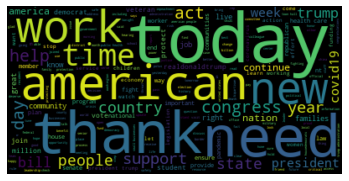

In [59]:
#WordCloud(ALL)

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [60]:
#political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
congress_tweets_R.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8...",16
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",13
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",28
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",9


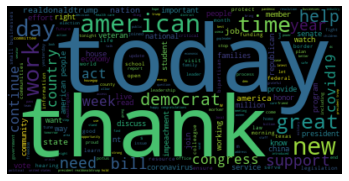

In [61]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [62]:
#political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
congress_tweets_D.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,...",11
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",23
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",21
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


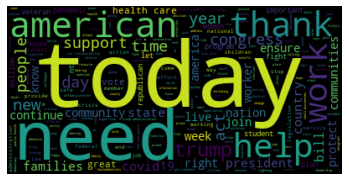

In [63]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [64]:
#Legislator position- Senator

congress_tweets_sen = congress_tweets[congress_tweets["position"]=="Sen"]
congress_tweets_sen.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
12,1.105870e+18,SenatorSinema,2019-03-13T12:36:37-04:00,"Among public institutions, @ASU is third in th...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[public, institutions, asu, nation, student, f...",12
24,1.249040e+18,SenatorSinema,2020-04-11T14:19:58-04:00,"Arizonans: if you've lost your job, been furlo...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[arizonans, ve, lost, job, furloughed, hours, ...",21
28,1.105590e+18,MartinHeinrich,2019-03-12T18:15:17-04:00,Proud that my bipartisan bill with @SenAlexand...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,Senate,Democrat,"319,667","385,234","415,335","335,788","[proud, bipartisan, bill, senalexander, signed...",23
34,1.105460e+18,PattyMurray,2019-03-12T09:12:00-04:00,ICYMI: The latest #TrumpBudget has massive tax...,Patty Murray,Sen,3-Jan-17,10/11/1950,F,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[icymi, latest, trumpbudget, massive, tax, bre...",24
35,1.186770e+18,McConnellPress,2019-10-22T18:12:22-04:00,RT @ARCgov ARC Federal Co-Chairman Tim Thomas:...,Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[arcgov, arc, federal, cochairman, tim, thomas...",24


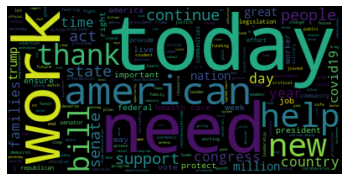

In [65]:
##WordCloud for Senators (NE ADDED)
# Convert list of tokens back to text string
text_sen = ' '.join(congress_tweets_sen['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_sen) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [66]:
#Legislator position- House of Representatives 

congress_tweets_hrep = congress_tweets[congress_tweets["position"]=="Rep"]
congress_tweets_hrep.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8...",16
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,...",11
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",13
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",23


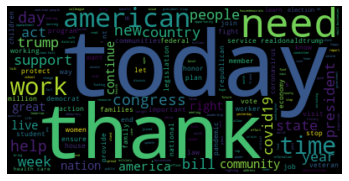

In [67]:
##WordCloud for House of Representatives (NE ADDED)
# Convert list of tokens back to text string
text_hrep = ' '.join(congress_tweets_hrep['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_hrep) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Wordcloud shows that the most frequently used words do not vary a lot by party(e.g., today, thank, american). However, it shows that the republicans use "great" and "new" more frequently, while democrats use "healthcare" and "communities" more frequently- which is expected.

## Wordcloud also shows that both Senates and Representatives use "today" and "need" a lot. But Senates use "work" more often while Representatives use "thank" more often.

## EDA 2. Topic modeling 

In [71]:
#create tf-idf matrix
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop) #creating an object : tf model

tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
dense_matrix = tfidf_matrix.todense() #remove all the columns where thre are 0

MemoryError: Unable to allocate 1.82 GiB for an array with shape (9437, 25856) and data type float64

In [ ]:
tfidf_matrix

In [ ]:
dense_matrix

In [ ]:
#initialize model/ prespecify the parameter n => "5 topics"
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0) #random_state for reproducibility
lda = lda.fit(dense_matrix) # pass through our dense matrix

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [ ]:
#prints out top words using different objects attached to our lda model
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)

In [ ]:
#get the topic distribution array
topic_dist = lda.transform(tfidf_matrix)
topic_dist

In [ ]:
#merge back with original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics

In [151]:
#check the average weight of each topic across "party" using groupby
grouped = df_w_topics.groupby('party')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

party
Independent    0.061677
Republican     0.053646
Democrat       0.047761
Name: 0, dtype: float64
party
Republican     0.058865
Democrat       0.052136
Independent    0.051210
Name: 1, dtype: float64
party
Independent    0.594156
Democrat       0.578776
Republican     0.551143
Name: 2, dtype: float64
party
Independent    0.049416
Democrat       0.048627
Republican     0.048304
Name: 3, dtype: float64
party
Independent    0.058596
Republican     0.042513
Democrat       0.038911
Name: 4, dtype: float64
party
Democrat       0.050599
Republican     0.047488
Independent    0.042417
Name: 5, dtype: float64
party
Republican     0.048900
Democrat       0.043706
Independent    0.022690
Name: 6, dtype: float64
party
Democrat       0.050621
Independent    0.050310
Republican     0.048601
Name: 7, dtype: float64
party
Republican     0.054072
Democrat       0.045328
Independent    0.018563
Name: 8, dtype: float64
party
Independent    0.050964
Republican     0.046467
Democrat       0.043536
Name

In [ ]:
#check the average weight of each topic across "position" using groupby
grouped2 = df_w_topics.groupby('position')
for i in range(0, 10):
    print(grouped[i].mean().sort_values(ascending=False))

## NE: I added a grouped by party too

## MJK All 10 topics do not seem to have a lot of separation between senators and representatives, but we will visualize Topic 0 and Topic 9 that show little more difference.
 

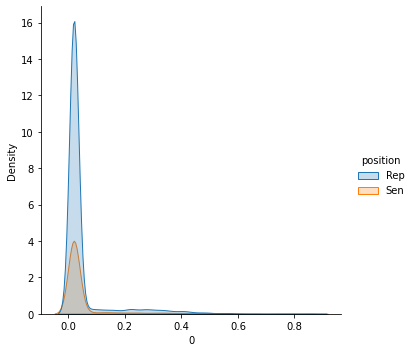

In [153]:
# Visualization- Topic 0 - for position
sns.displot(df_w_topics, x=df_w_topics[0], hue = "position", kind = 'kde', fill = 'true')
plt.show()

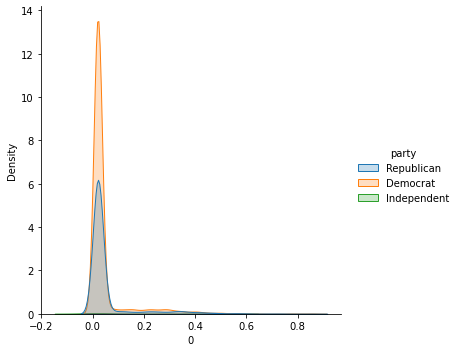

In [154]:
# Visualization- Topic 0 - for party 
sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
plt.show()

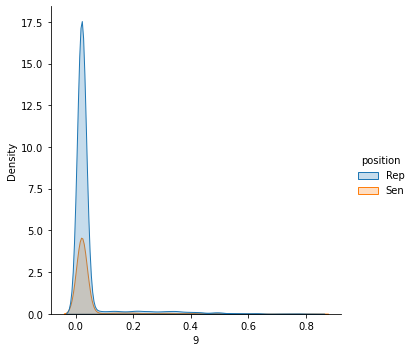

In [155]:
# Visualization- Topic 9 - for position
sns.displot(df_w_topics, x=df_w_topics[9], hue = "position", kind = 'kde', fill = 'true')
plt.show()

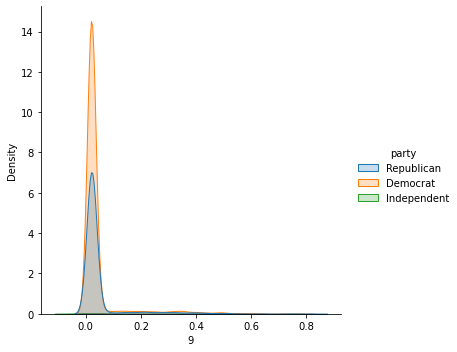

In [156]:
# Visualization- Topic 9 - for party 
sns.displot(df_w_topics, x=df_w_topics[9], hue = "party", kind = 'kde', fill = 'true')
plt.show()

## NE: I added visualizations for party too 

## MJK: The visualizations show that the topics would NOT be good candidates to pass to a supervised learning algorithm if we were interested in predicting the position(senate/representative).

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

In [74]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text)) 
congress_tweets['tokens'].head()

0    oh14 salutes patrolman st clair    fox8news 5y...
1    case missed bipartisanship works – bill eradic...
2     wishing happy passover celebrating seder tonight
3    whitehouse president realdonaldtrump signed bi...
4    sent letter demanding administration stop play...
Name: tokens, dtype: object

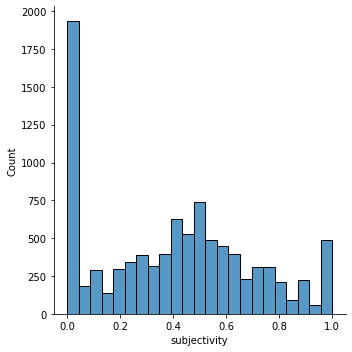

In [75]:
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

In [76]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,subjectivity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",oh14 salutes patrolman st clair fox8news 5y...,16,0.0
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",case missed bipartisanship works – bill eradic...,11,0.0
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869",wishing happy passover celebrating seder tonight,6,1.0
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",whitehouse president realdonaldtrump signed bi...,13,0.0
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",sent letter demanding administration stop play...,23,1.0


##   Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Although the overall distribution is normal, more tweets were factual information(subjectivity ==0) compared to opinions(subjectivity ==1).

## 2) Choose two legislators, one liberal and one conservative

In [77]:
# Republican: David Joyce
congress_tweets_R.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8...",16
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",13
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",28
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",9


In [78]:
congress_tweets_DavidJoyce = congress_tweets['text'][0]
print(congress_tweets_DavidJoyce)


All of #OH14 salutes you, Patrolman St. Clair!   QT @fox8news 5-year-old battling cancer becomes Bainbridge police officer for the day  via @RooseveltLFOX8


In [79]:
congress_tweets_DavidJoyce = "All of #OH14 salutes you, Patrolman St. Clair! 👮‍♂️ https://twitter.com/fox8news/status/1182779635840495622 QT @fox8news 5-year-old battling cancer becomes Bainbridge police officer for the day http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ via @RooseveltLFOX8"
print("overall subjectivity score for David Joyce(Republican) is", TextBlob(congress_tweets_DavidJoyce).sentiment.subjectivity)
for word in congress_tweets_DavidJoyce.split():
    print(word, TextBlob(word).sentiment.subjectivity)

overall subjectivity score for David Joyce(Republican) is 0.0
All 0.0
of 0.0
#OH14 0.0
salutes 0.0
you, 0.0
Patrolman 0.0
St. 0.0
Clair! 0.0
👮‍♂️ 0.0
https://twitter.com/fox8news/status/1182779635840495622 0.0
QT 0.0
@fox8news 0.0
5-year-old 0.0
battling 0.0
cancer 0.0
becomes 0.0
Bainbridge 0.0
police 0.0
officer 0.0
for 0.0
the 0.0
day 0.0
http://fox8.com/2019/10/11/5-year-old-battling-cancer-becomes-bainbridge-police-officer-for-the-day/ 0.0
via 0.0
@RooseveltLFOX8 0.0


## The overall subjectivity score for David Joyce(Republican) is 0.0

In [80]:
# Democrat: Josh Harder
congress_tweets_D.head()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, –, bill,...",11
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",23
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",21
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


In [81]:
congress_tweets_JoshHarder = congress_tweets['text'][1]
print(congress_tweets_JoshHarder)

In Case You Missed It: Bipartisanship works – and now my bill to eradicate swamp rats is becoming law!



In [82]:
congress_tweets_JoshHarder = "In Case You Missed It: Bipartisanship works – and now my bill to eradicate swamp rats is becoming law! https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/"
print("overall subjectivity score for Josh Harder(Democrat) is", TextBlob(congress_tweets_JoshHarder).sentiment.subjectivity)
for word in congress_tweets_JoshHarder.split():
    print(word, TextBlob(word).sentiment.subjectivity)

overall subjectivity score for Josh Harder(Democrat) is 0.8500000000000001
In 0.0
Case 0.0
You 0.0
Missed 0.0
It: 0.0
Bipartisanship 0.0
works 0.0
– 0.0
and 0.0
now 0.0
my 0.0
bill 0.0
to 0.0
eradicate 0.0
swamp 0.0
rats 0.0
is 0.0
becoming 0.8500000000000001
law! 0.0
https://www.turlockjournal.com/news/government/president-to-sign-harders-nutria-bill-into-law/ 0.0


## The overall subjectivity score for Josh Harder(Democrat) is 0.85

## 3-1)  compare Democrats v. Republicans 

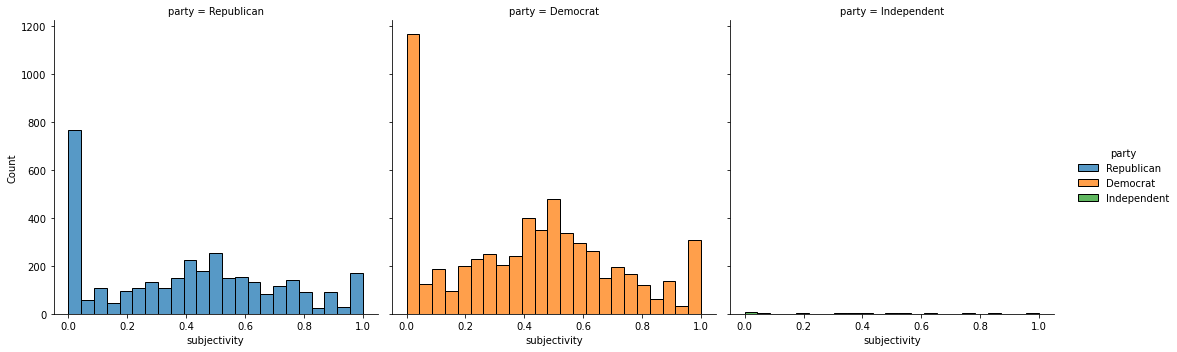

In [83]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

## Democrats tend to post more factual information(subjectivity ==0) than republicans

## 3-2) compare Senators v. Representatives 

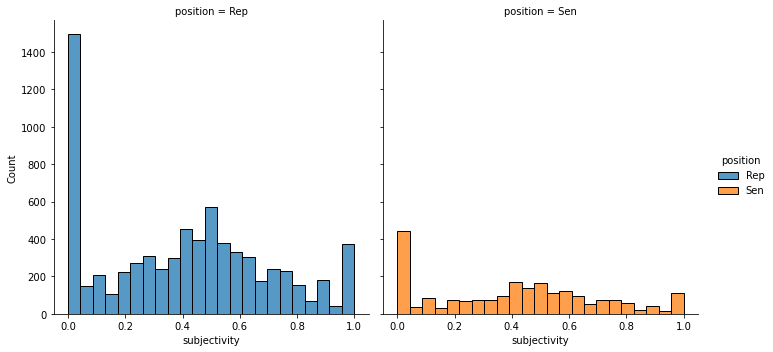

In [84]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

## Representatives tend to post more factual information(subjectivity ==0) than Senators

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [173]:
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text)) #made into string
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [174]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'length_tokens', 'subjectivity',
       'polarity'],
      dtype='object')

In [175]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437",o h 1 4 s a l u t e s ...,16,0.0,0.0
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",c a s e m i s s e d ...,10,0.0,0.0
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869",w i s h i n g h a p p ...,6,0.0,0.0
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",w h i t e h o u s e p ...,13,0.0,0.0
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431",s e n t l e t t e r ...,23,0.0,0.0


### Engineered Text Features

In [176]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

In [177]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,5,6,7,8,9,polarity,subjectivity
0,0.020774,0.020774,0.313928,0.020775,0.519879,0.020774,0.020774,0.020774,0.020774,0.020774,0.0,0.0
1,0.024621,0.408337,0.394706,0.024624,0.024620,0.024618,0.024619,0.024619,0.024620,0.024618,0.0,0.0
2,0.029562,0.029567,0.029625,0.029562,0.193296,0.029562,0.570139,0.029562,0.029563,0.029563,0.0,0.0
3,0.022671,0.022671,0.600728,0.022671,0.022672,0.022671,0.022671,0.217904,0.022671,0.022671,0.0,0.0
4,0.074134,0.017741,0.737033,0.017741,0.017741,0.064645,0.017742,0.017741,0.017741,0.017742,0.0,0.0


### Bag-of-words or Tf-idf

In [180]:
# Frequency Based featurization
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

In [181]:
tfidf_df.head()

,,,,,,,,,,,...,🧔,🧙,🧡,🧬,🧵,🧹,🧼,🩺,🫂,🫐
0,0.0,0.950967,0.126621,0.000000,0.0,0.0,0.0,0.0,0.027971,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.939613,0.188801,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.952598,0.129331,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.957326,0.129022,0.030630,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.954080,0.161034,0.020025,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding - N STOPPED HERE 

In [182]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [183]:
#Using the function to re-tokenize
congress_tweets['tokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))

#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=3, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [184]:
len(congress_tweets['tokens'][0])

16

In [185]:
doc = [word for word in congress_tweets['tokens'][0] if word in model.wv.index_to_key]
len(doc)

8

In [186]:
doc [0:5]

['st', '  ', 'battling', 'cancer', 'police']

In [187]:
#Now let's grab the first vector each token and take their mean:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

-0.12406352

In [188]:
#create this for every word - get all the means (FROM LAB)
#Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#get an average embedding for each doument 
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [189]:
# Initialize an array for the size of the corpus
#each word is represented by 100 element list, so then it averages the first element for each word across all the words
empty_list_embeddings_means = []
for doc in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

##I KEEP GETTING AN ERROR THAT SAYS "NEED AT LEAST ONE ARRAY TO CONCATENATE"

ValueError: need at least one array to concatenate

In [190]:
doc_average_embeddings
#do this because trying to average elements in a document - trying to make vectors for documents, to then use doc2vec

NameError: name 'doc_average_embeddings' is not defined

In [191]:
#now have a 1000 documents (complaints) and each has 100 features/elements (first number in an array of a word)
#e.g., first number see above in contacting 
#AVE EMBEDDINGS FOR EACH DOC 
doc_average_embeddings.shape

NameError: name 'doc_average_embeddings' is not defined

In [192]:
word2vec_features_df = pd.DataFrame(doc_average_embeddings) #CREATE DATAFRAME 

NameError: name 'doc_average_embeddings' is not defined

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**